In [146]:
import urllib.request
import requests
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#os.environ["Token1"] = "your personal access token1"
#os.environ["Token2"] = "your personal access token2"

# Projects

In [148]:
def load_projects():
    with urllib.request.urlopen('https://api.github.com/orgs/delta-io/repos') as response:
        delta_json_obj = json.load(response)
    delta_proj_repos = []
    for i in delta_json_obj:
        delta_proj_repos.append(i['full_name'])
        
    all_proj_repos = ['apache/iceberg','apache/hudi']
    all_proj_repos.extend(delta_proj_repos)

    return all_proj_repos

In [149]:
all_proj_repos = load_projects()

In [9]:
print(all_proj_repos)

['apache/iceberg', 'apache/hudi', 'delta-io/delta', 'delta-io/delta-examples', 'delta-io/connectors', 'delta-io/delta-rs', 'delta-io/website', 'delta-io/kafka-delta-ingest', 'delta-io/delta-sharing', 'delta-io/delta-docs']


# All Project Contributors

In [10]:
def load_project_contributors():
    all_proj_contributors = []
    for i in all_proj_repos:
        all_proj_contributors.append({'repo':str(i), 'contributors':''})
    
    for i in all_proj_contributors:
        url = 'https://api.github.com/repos/'+str(i['repo'])+'/contributors?per_page=100&page=1'
        response = requests.get(url,headers={"Authorization": 'token '+os.environ["Token1"]})
        i['contributors'] = response.json()
        while 'next' in response.links.keys():
            response = requests.get(response.links['next']['url'],headers={"Authorization": 'token '+os.environ["Token1"]})
            i['contributors'].extend(response.json())
    
    df_all_proj_contributors = pd.json_normalize([user for user in all_proj_contributors],
                 record_path = ['contributors'],
                 meta = ['repo'],
                 errors = 'ignore'
                 )[['login','url','contributions','repo']]
    
    conditions = [
        (df_all_proj_contributors['repo'].str.contains('delta-io') ),
        (df_all_proj_contributors['repo'].str.contains('iceberg') ),
        (df_all_proj_contributors['repo'].str.contains('hudi') )
    ]

    values = ['delta','iceberg','hudi']
    
    df_all_proj_contributors['project'] = np.select(conditions, values)

    return df_all_proj_contributors

In [7]:
df_all_proj_contributors = load_project_contributors()

In [11]:
df_all_proj_contributors.head()

,login,url,contributions,repo,project
0,rdblue,https://api.github.com/users/rdblue,667,apache/iceberg,iceberg
1,aokolnychyi,https://api.github.com/users/aokolnychyi,329,apache/iceberg,iceberg
2,Fokko,https://api.github.com/users/Fokko,285,apache/iceberg,iceberg
3,nastra,https://api.github.com/users/nastra,205,apache/iceberg,iceberg
4,kbendick,https://api.github.com/users/kbendick,181,apache/iceberg,iceberg


In [11]:
#df_all_proj_contributors.to_csv("all_proj_contributors.csv", index=False)

In [4]:
#df_all_proj_contributors = pd.read_csv('all_proj_contributors.csv')

# Unique Contributor Profiles

In [12]:
def load_unique_profiles():
    df_unique_contributors = df_all_proj_contributors['url'].unique()
    unique_profiles = []
    for i in df_unique_contributors:
        req = urllib.request.Request(i)
        req.add_header('Authorization', 'token '+os.environ["Token1"])
        #progress_contributors.progress(j+1)
        with urllib.request.urlopen(req) as response:
                unique_profiles.append(json.load(response))
    
    df_unique_profiles = pd.DataFrame(unique_profiles, columns = ['login','company','email','created_at','updated_at'])
    
    return df_unique_profiles

In [14]:
df_unique_profiles = load_unique_profiles()

In [15]:
df_unique_profiles.head()

,login,company,email,created_at,updated_at
0,rdblue,"Tabular, @tabular-io",blue@apache.org,2009-05-23T22:01:55Z,2023-01-23T19:25:33Z
1,aokolnychyi,Apple,aokolnychyi@apache.org,2013-12-21T10:19:19Z,2023-04-05T02:56:26Z
2,Fokko,@tabular-io,fokko@driesprong.frl,2011-10-17T20:40:53Z,2023-03-09T09:16:21Z
3,nastra,@tabular-io,etudenhoefner@gmail.com,2010-05-08T08:58:58Z,2023-04-04T14:46:58Z
4,kbendick,@tabular-io,None,2014-11-19T00:02:08Z,2023-01-21T18:02:15Z


In [16]:
#df_unique_profiles.to_csv("unique_profiles.csv", index=False)

In [11]:
#df_unique_profiles = pd.read_csv('unique_profiles.csv')

# Pull Requests

In [18]:
def load_project_pulls():
    all_proj_pulls = []
    for i in all_proj_repos:
        all_proj_pulls.append({'repo':str(i), 'pulls':''})
    
    for i in all_proj_pulls:
        url = 'https://api.github.com/repos/'+str(i['repo'])+'/pulls?state=all&page=1'
        response = requests.get(url,headers={"Authorization": 'token '+os.environ["Token2"]})
        i['pulls'] = response.json()
        while 'next' in response.links.keys():
            response = requests.get(response.links['next']['url'],headers={"Authorization": 'token '+os.environ["Token2"]})
            i['pulls'].extend(response.json())
    
    # flatten the JSON payload into a dataframe, only keeping fields needed
    df_pulls = pd.json_normalize([pull for pull in all_proj_pulls],
                            record_path = ['pulls'],
                            meta = ['repo'])[['repo','id','number','state','user.login','created_at','updated_at','closed_at','merged_at']]
    
    df_pulls = df_pulls.rename(columns={'user.login':'login'})
    
    conditions = [
        (df_pulls['repo'].str.contains('delta-io') ),
        (df_pulls['repo'].str.contains('iceberg') ),
        (df_pulls['repo'].str.contains('hudi') )
    ]

    values = ['delta','iceberg','hudi']
    
    df_pulls['project'] = np.select(conditions, values)
    
    return df_pulls

In [19]:
df_pulls = load_project_pulls()

In [15]:
df_pulls.head()

,repo,id,number,state,login,created_at,updated_at,closed_at,merged_at,project
0,apache/iceberg,1302193390,7279,open,singhpk234,2023-04-04T19:46:53Z,2023-04-04T19:58:48Z,NaN,NaN,iceberg
1,apache/iceberg,1300646735,7277,open,ericlgoodman,2023-04-03T20:22:45Z,2023-04-03T20:35:25Z,NaN,NaN,iceberg
2,apache/iceberg,1300535068,7275,open,abmo-x,2023-04-03T18:56:46Z,2023-04-04T20:48:39Z,NaN,NaN,iceberg
3,apache/iceberg,1300509171,7274,closed,danielcweeks,2023-04-03T18:32:47Z,2023-04-03T18:36:14Z,2023-04-03T18:36:14Z,NaN,iceberg
4,apache/iceberg,1300427050,7273,closed,amogh-jahagirdar,2023-04-03T17:25:39Z,2023-04-04T18:52:15Z,2023-04-03T22:02:48Z,2023-04-03T22:02:48Z,iceberg


In [14]:
#df_pulls.to_csv("pulls.csv", index=False)

In [13]:
#df_pulls = pd.read_csv('pulls.csv')

# Commits

In [144]:
def load_project_commits():
    all_proj_commits = []
    for i in all_proj_repos:
        all_proj_commits.append({'repo':str(i), 'commits':''})
    
    for i in all_proj_commits:
        url = 'https://api.github.com/repos/'+str(i['repo'])+'/commits?state=all&page=1'
        response = requests.get(url,headers={"Authorization": 'token '+os.environ["Token2"]})
        i['commits'] = response.json()
        while 'next' in response.links.keys():
            response = requests.get(response.links['next']['url'],headers={"Authorization": 'token '+os.environ["Token2"]})
            i['commits'].extend(response.json())
    
    # flatten the JSON payload into a dataframe, only keeping fields needed
    df_commits = pd.json_normalize([commit for commit in all_proj_commits],
                            record_path = ['commits'],
                            meta = ['repo'])[['repo','commit.author.date','author.login']]
    
    df_commits = df_commits.rename(columns={'author.login':'login'})
    df_commits = df_commits.rename(columns={'commit.author.date':'created_at'})
    
    conditions = [
        (df_commits['repo'].str.contains('delta-io') ),
        (df_commits['repo'].str.contains('iceberg') ),
        (df_commits['repo'].str.contains('hudi') )
    ]

    values = ['delta','iceberg','hudi']
    
    df_commits['project'] = np.select(conditions, values)

    return df_commits

In [150]:
df_commits = load_project_commits()

In [151]:
df_commits.head()

,repo,created_at,login,project
0,apache/iceberg,2023-04-16T19:30:24Z,dependabot[bot],iceberg
1,apache/iceberg,2023-04-16T19:18:40Z,dependabot[bot],iceberg
2,apache/iceberg,2023-04-16T18:34:23Z,dependabot[bot],iceberg
3,apache/iceberg,2023-04-16T03:58:29Z,chenjunjiedada,iceberg
4,apache/iceberg,2023-04-15T01:16:37Z,pavibhai,iceberg


In [26]:
#df_commits.to_csv("commits.csv", index=False)

In [159]:
#df_commits = pd.read_csv('commits.csv')

# Clean Company Values

In [16]:
# make capitalization consistent
df_unique_profiles[['company_clean']] = df_unique_profiles['company'].str.lower()
df_unique_profiles.head()

,login,company,email,created_at,updated_at,company_clean
0,rdblue,"Tabular, @tabular-io",blue@apache.org,2009-05-23T22:01:55Z,2023-01-23T19:25:33Z,"tabular, @tabular-io"
1,aokolnychyi,Apple,aokolnychyi@apache.org,2013-12-21T10:19:19Z,2023-01-10T00:20:45Z,apple
2,Fokko,@tabular-io,fokko@driesprong.frl,2011-10-17T20:40:53Z,2023-03-09T09:16:21Z,@tabular-io
3,nastra,@tabular-io,etudenhoefner@gmail.com,2010-05-08T08:58:58Z,2023-04-04T14:46:58Z,@tabular-io
4,kbendick,@tabular-io,NaN,2014-11-19T00:02:08Z,2023-01-21T18:02:15Z,@tabular-io


In [17]:
# extract email domains, which will be used in case "company" is null
df_unique_profiles[['email_domain']] = df_unique_profiles['email'].str.split('@', expand=True)[1]
df_unique_profiles['email_domain'] = df_unique_profiles['email_domain'].str.lower()
df_unique_profiles.head()

,login,company,email,created_at,updated_at,company_clean,email_domain
0,rdblue,"Tabular, @tabular-io",blue@apache.org,2009-05-23T22:01:55Z,2023-01-23T19:25:33Z,"tabular, @tabular-io",apache.org
1,aokolnychyi,Apple,aokolnychyi@apache.org,2013-12-21T10:19:19Z,2023-01-10T00:20:45Z,apple,apache.org
2,Fokko,@tabular-io,fokko@driesprong.frl,2011-10-17T20:40:53Z,2023-03-09T09:16:21Z,@tabular-io,driesprong.frl
3,nastra,@tabular-io,etudenhoefner@gmail.com,2010-05-08T08:58:58Z,2023-04-04T14:46:58Z,@tabular-io,gmail.com
4,kbendick,@tabular-io,NaN,2014-11-19T00:02:08Z,2023-01-21T18:02:15Z,@tabular-io,NaN


In [18]:
## Define matching conditions
company_patterns = [
    [df_unique_profiles['company_clean'].str.contains('databricks', na=False, regex=False), 'databricks'],
    [df_unique_profiles['company_clean'].str.contains('tabular', na=False, regex=False), 'tabular'],
    [df_unique_profiles['company_clean'].str.contains('apple', na=False, regex=False), 'apple'],
    [df_unique_profiles['company_clean'].str.contains('adobe', na=False, regex=False), 'adobe'],
    [df_unique_profiles['company_clean'].str.contains('netflix', na=False, regex=False), 'netflix'],
    [df_unique_profiles['company_clean'].str.contains('starburst', na=False, regex=False), 'starburst'],
    [df_unique_profiles['company_clean'].str.contains('aws', na=False, regex=False), 'amazon'],
    [df_unique_profiles['company_clean'].str.contains('amazon', na=False, regex=False), 'amazon'],
    [df_unique_profiles['company_clean'].str.contains('tencent', na=False, regex=False), 'amazon'],
    [df_unique_profiles['company_clean'].str.contains('ibm', na=False, regex=False), 'amazon'],
    [df_unique_profiles['company_clean'].str.contains('bytedance', na=False, regex=False), 'bytedance'],
    [df_unique_profiles['company_clean'].str.contains('robinhood', na=False, regex=False), 'robinhood'],
    [df_unique_profiles['company_clean'].str.contains('alibaba', na=False, regex=False), 'alibaba'],
    [df_unique_profiles['company_clean'].str.contains('netease', na=False, regex=False), 'netease'],
    [df_unique_profiles['company_clean'].str.contains('microsoft', na=False, regex=False), 'microsoft'],
    [df_unique_profiles['company_clean'].str.contains('salesforce', na=False, regex=False), 'salesforce'],
    [df_unique_profiles['company_clean'].str.contains('safegraph', na=False, regex=False), 'safegraph'],
    [df_unique_profiles['company_clean'].str.contains('uber', na=False, regex=False), 'uber'],
    [df_unique_profiles['company_clean'].str.contains('linkedin', na=False, regex=False), 'linkedin'],
    [df_unique_profiles['company_clean'].str.contains('huawei', na=False, regex=False), 'huawei'],
    [df_unique_profiles['email_domain'].str.contains('databricks', na=False, regex=False), 'databricks'],
    [df_unique_profiles['email_domain'].str.contains('linkedin', na=False, regex=False), 'linkedin'],
    [df_unique_profiles['email_domain'].str.contains('amazon', na=False, regex=False), 'amazon'],
    [df_unique_profiles['email_domain'].str.contains('apple', na=False, regex=False), 'apple'],
    [df_unique_profiles['email_domain'].str.contains('robinhood', na=False, regex=False), 'robinhood']
]

In [19]:
# remove any mentions of former employers, not to be mistaken for current
df_unique_profiles['company_clean'] = df_unique_profiles['company_clean'].str.split('ex ', expand=True)[0]
df_unique_profiles['company_clean'] = df_unique_profiles['company_clean'].str.split('ex-', expand=True)[0]

In [20]:
## Update create company_clean column using clean values
company_criteria, company_values = zip(*company_patterns)
df_unique_profiles['company_clean_2'] = np.select(company_criteria, company_values, None)
df_unique_profiles['company_clean'] = df_unique_profiles['company_clean'].replace({'@': ''}, regex=True)
df_unique_profiles['company_clean_3'] = df_unique_profiles['company_clean_2'].combine_first(df_unique_profiles['company_clean'])
df_unique_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_unique_profiles.head()

,login,company,email,created_at,updated_at,company_clean,email_domain,company_clean_2,company_clean_3
0,rdblue,"Tabular, @tabular-io",blue@apache.org,2009-05-23T22:01:55Z,2023-01-23T19:25:33Z,"tabular, tabular-io",apache.org,tabular,tabular
1,aokolnychyi,Apple,aokolnychyi@apache.org,2013-12-21T10:19:19Z,2023-01-10T00:20:45Z,apple,apache.org,apple,apple
2,Fokko,@tabular-io,fokko@driesprong.frl,2011-10-17T20:40:53Z,2023-03-09T09:16:21Z,tabular-io,driesprong.frl,tabular,tabular
3,nastra,@tabular-io,etudenhoefner@gmail.com,2010-05-08T08:58:58Z,2023-04-04T14:46:58Z,tabular-io,gmail.com,tabular,tabular
4,kbendick,@tabular-io,NaN,2014-11-19T00:02:08Z,2023-01-21T18:02:15Z,tabular-io,NaN,tabular,tabular


# Analysis

## How many pull requests per project?

In [116]:
df_pulls_by_project = df_pulls[['project', 'created_at']]
df_pulls_by_project['created_at_date'] = pd.to_datetime(df_pulls_by_project['created_at'], format="%Y-%m-%dT%H:%M:%SZ").dt.date
df_pulls_by_project = df_pulls_by_project.groupby(['created_at_date', 'project'], as_index=False).size().rename(columns={'size':'pulls'})
df_pulls_by_project = df_pulls_by_project.sort_values(by='created_at_date', ascending=True)
df_pulls_by_project.head()

<ipython-input-116-281c31a24f0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulls_by_project['created_at_date'] = pd.to_datetime(df_pulls_by_project['created_at'], format="%Y-%m-%dT%H:%M:%SZ").dt.date


,created_at_date,project,pulls
0,2016-12-17,hudi,1
1,2016-12-20,hudi,2
2,2016-12-21,hudi,1
3,2016-12-28,hudi,1
4,2016-12-29,hudi,1


In [93]:
#df_pulls_by_project_test = df_pulls_by_project.groupby(['project'], as_index=False).sum('pulls')
#df_pulls_by_project_test.head()

,project,pulls
0,delta,2395
1,hudi,6113
2,iceberg,5070


In [117]:
df_pulls_delta = df_pulls_by_project[df_pulls_by_project['project'] == 'delta']
df_pulls_iceberg = df_pulls_by_project[df_pulls_by_project['project'] == 'iceberg']
df_pulls_hudi = df_pulls_by_project[df_pulls_by_project['project'] == 'hudi']

In [134]:
df_pulls_all_dates = df_pulls_by_project.loc[:,['created_at_date']]
df_pulls_all_dates = df_pulls_all_dates.drop_duplicates(subset='created_at_date', keep='first')
df_pulls_all_dates['created_at_date'].duplicated(keep=False).any()

False

In [135]:
df_pulls_all_dates = pd.merge(df_pulls_all_dates, df_pulls_delta, on='created_at_date', how='left').rename(columns={'pulls':'delta'})
df_pulls_all_dates = pd.merge(df_pulls_all_dates, df_pulls_iceberg[['created_at_date','pulls']], on='created_at_date', how='left').rename(columns={'pulls':'iceberg'})
df_pulls_all_dates = pd.merge(df_pulls_all_dates, df_pulls_hudi[['created_at_date','pulls']], on='created_at_date', how='left').rename(columns={'pulls':'hudi'})
df_pulls_all_dates = df_pulls_all_dates.drop(labels='project', axis=1)
df_pulls_all_dates = df_pulls_all_dates.fillna(0)
df_pulls_all_dates.head()

,created_at_date,delta,iceberg,hudi
0,2016-12-17,0.0,0.0,1.0
1,2016-12-20,0.0,0.0,2.0
2,2016-12-21,0.0,0.0,1.0
3,2016-12-28,0.0,0.0,1.0
4,2016-12-29,0.0,0.0,1.0


In [160]:
#df_pulls_all_dates['delta'].sum()
#df_pulls_all_dates['iceberg'].sum()
#df_pulls_all_dates['hudi'].sum()

In [138]:
df_pulls_all_dates['delta_cumsum'] = df_pulls_all_dates['delta'].cumsum()
df_pulls_all_dates['iceberg_cumsum'] = df_pulls_all_dates['iceberg'].cumsum()
df_pulls_all_dates['hudi_cumsum'] = df_pulls_all_dates['hudi'].cumsum()
df_pulls_all_dates = df_pulls_all_dates.sort_values(by='created_at_date', ascending=False)
df_pulls_all_dates.head()

,created_at_date,delta,iceberg,hudi,delta_cumsum,iceberg_cumsum,hudi_cumsum
1677,2023-04-04,4.0,1.0,7.0,2395.0,5070.0,6113.0
1676,2023-04-03,8.0,6.0,5.0,2391.0,5069.0,6106.0
1675,2023-04-02,0.0,4.0,6.0,2383.0,5063.0,6101.0
1674,2023-04-01,0.0,3.0,7.0,2383.0,5059.0,6095.0
1673,2023-03-31,0.0,11.0,9.0,2383.0,5056.0,6088.0


In [74]:
#df_pulls_all_dates.to_csv("df_pulls_all_dates", index=False)

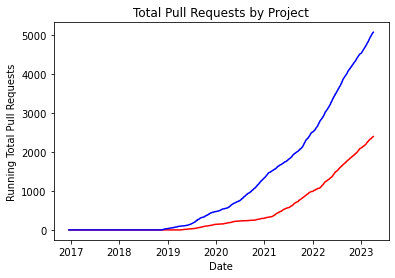

In [139]:
df_pulls_all_dates.set_index('created_at_date', inplace=True)
fig, ax = plt.subplots()
ax.plot(df_pulls_all_dates['delta_cumsum'], color='red')
ax.plot(df_pulls_all_dates['iceberg_cumsum'], color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Running Total Pull Requests')
ax.set_title('Total Pull Requests by Project')
plt.show()

## How many pull requests by company?

In [141]:
df_pulls_profiles = pd.merge(df_pulls, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_pulls_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_pulls_profiles.head()

,repo,id,number,state,login,created_at,updated_at,closed_at,merged_at,project,company_clean_3
0,apache/iceberg,1312930537,7343,open,szehon-ho,2023-04-13T18:00:18Z,2023-04-13T18:00:34Z,None,None,iceberg,apple
1,apache/iceberg,1312808767,7342,open,dependabot[bot],2023-04-13T16:35:58Z,2023-04-13T16:36:14Z,None,None,iceberg,unknown
2,apache/iceberg,1312751368,7341,closed,nastra,2023-04-13T15:51:41Z,2023-04-13T17:41:14Z,2023-04-13T17:38:08Z,2023-04-13T17:38:08Z,iceberg,tabular
3,apache/iceberg,1312457174,7339,open,nastra,2023-04-13T12:49:18Z,2023-04-13T17:43:18Z,None,None,iceberg,tabular
4,apache/iceberg,1312403475,7338,open,chenjunjiedada,2023-04-13T12:11:36Z,2023-04-13T14:53:51Z,None,None,iceberg,amazon


In [142]:
df_pulls_by_company = df_pulls_profiles[['project','company_clean_3']].groupby(['project','company_clean_3'], as_index=False, dropna=False).size().rename(columns={'size':'company_pulls'})
df_pulls_by_company.sort_values(by='company_pulls', ascending=False).head()

,project,company_clean_3,company_pulls
152,hudi,unknown,3227
238,iceberg,unknown,1518
69,delta,unknown,1370
228,iceberg,tabular,1318
130,hudi,onehouse,834


In [144]:
df_pulls_by_project = df_pulls_profiles[['project']].groupby(['project'], as_index=False).size().rename(columns={'size':'project_pulls'})
df_pulls_by_project.sort_values(by='project_pulls', ascending=False).head()

,project,project_pulls
1,hudi,6164
2,iceberg,5103
0,delta,2436


In [145]:
df_pulls_by_company = pd.merge(df_pulls_by_company,df_pulls_by_project, on='project', how='left')
df_pulls_by_company[['company_pct_project_pulls']] = 100*(df_pulls_by_company['company_pulls']/df_pulls_by_company['project_pulls'])
df_pulls_by_company.sort_values(by='company_pct_project_pulls', ascending=False).head()

,project,company_clean_3,company_pulls,project_pulls,company_pct_project_pulls
69,delta,unknown,1370,2436,56.239737
152,hudi,unknown,3227,6164,52.352369
238,iceberg,unknown,1518,5103,29.747208
228,iceberg,tabular,1318,5103,25.827944
22,delta,databricks,610,2436,25.041051


In [146]:
df_pulls_by_company_delta = df_pulls_by_company[df_pulls_by_company['project'] == 'delta'].sort_values(by='company_pct_project_pulls', ascending=False)
df_pulls_by_company_iceberg = df_pulls_by_company[df_pulls_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_pulls', ascending=False)
df_pulls_by_company_hudi = df_pulls_by_company[df_pulls_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_pulls', ascending=False)

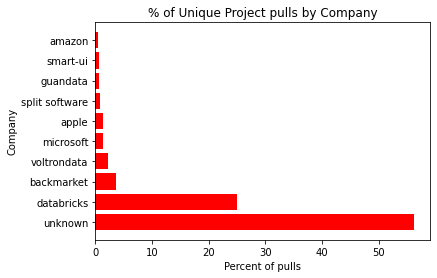

In [148]:
plt.barh(df_pulls_by_company_delta['company_clean_3'].head(10), df_pulls_by_company_delta['company_pct_project_pulls'].head(10), color = "red")
plt.xlabel("Percent of pulls") 
plt.ylabel("Company") 
plt.title("% of Unique Project pulls by Company")
plt.show()

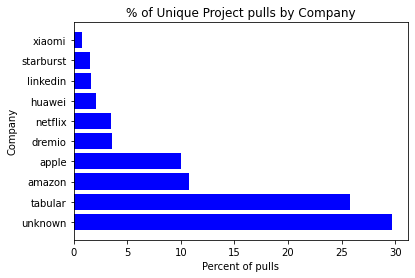

In [149]:
plt.barh(df_pulls_by_company_iceberg['company_clean_3'].head(10), df_pulls_by_company_iceberg['company_pct_project_pulls'].head(10), color = "blue")
plt.xlabel("Percent of pulls") 
plt.ylabel("Company") 
plt.title("% of Unique Project pulls by Company")
plt.show()

## How many unique pull requesters by company?

In [150]:
df_unique_pullers = df_pulls[['login','project']].drop_duplicates(subset='login', keep='first')
df_unique_pullers_profiles = pd.merge(df_unique_pullers, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_pulls_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_unique_pullers_profiles.head()

,login,project,company_clean_3
0,szehon-ho,iceberg,apple
1,dependabot[bot],iceberg,unknown
2,nastra,iceberg,tabular
3,chenjunjiedada,iceberg,amazon
4,ajantha-bhat,iceberg,dremio


In [151]:
df_pullers_by_company = df_unique_pullers_profiles[['project','company_clean_3']].groupby(['project','company_clean_3'], as_index=False).size().rename(columns={'size':'company_pullers'})
df_pullers_by_company.sort_values(by='company_pullers', ascending=False).head()

,project,company_clean_3,company_pullers
136,hudi,unknown,219
222,iceberg,unknown,162
61,delta,unknown,113
20,delta,databricks,35
147,iceberg,amazon,26


In [152]:
df_pullers_by_project = df_unique_pullers_profiles[['project']].groupby(['project'], as_index=False).size().rename(columns={'size':'project_pullers'})
df_pullers_by_project.sort_values(by='project_pullers', ascending=False).head()

,project,project_pullers
1,hudi,457
2,iceberg,448
0,delta,306


In [153]:
df_pullers_by_company = pd.merge(df_pullers_by_company,df_pullers_by_project, on='project', how='left')
df_pullers_by_company[['company_pct_project_pullers']] = 100*(df_pullers_by_company['company_pullers']/df_pullers_by_company['project_pullers'])
df_pullers_by_company.sort_values(by='company_pct_project_pullers', ascending=False).head()

,project,company_clean_3,company_pullers,project_pullers,company_pct_project_pullers
136,hudi,unknown,219,457,47.921225
61,delta,unknown,113,306,36.928105
222,iceberg,unknown,162,448,36.160714
20,delta,databricks,35,306,11.437908
147,iceberg,amazon,26,448,5.803571


In [154]:
df_pullers_by_company_delta = df_pullers_by_company[df_pullers_by_company['project'] == 'delta'].sort_values(by='company_pct_project_pullers', ascending=False)
df_pullers_by_company_iceberg = df_pullers_by_company[df_pullers_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_pullers', ascending=False)
df_pullers_by_company_hudi = df_pullers_by_company[df_pullers_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_pullers', ascending=False)

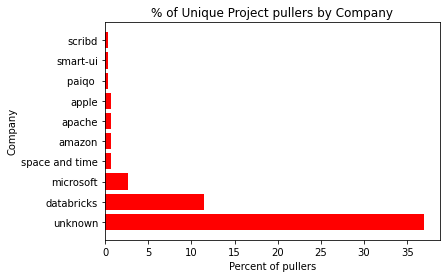

In [155]:
plt.barh(df_pullers_by_company_delta['company_clean_3'].head(10), df_pullers_by_company_delta['company_pct_project_pullers'].head(10), color = "red")
plt.xlabel("Percent of pullers") 
plt.ylabel("Company") 
plt.title("% of Unique Project pullers by Company")
plt.show()

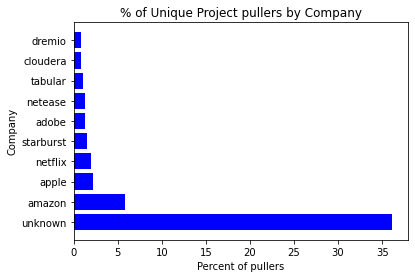

In [156]:
plt.barh(df_pullers_by_company_iceberg['company_clean_3'].head(10), df_pullers_by_company_iceberg['company_pct_project_pullers'].head(10), color = "blue")
plt.xlabel("Percent of pullers") 
plt.ylabel("Company") 
plt.title("% of Unique Project pullers by Company")
plt.show()

## How many commits by company?

In [157]:
df_commits_profiles = pd.merge(df_commits, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_commits_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_commits_profiles.head()

,repo,created_at,login,project,company_clean_3
0,apache/iceberg,2023-04-13T19:00:55Z,gustavoatt,iceberg,unknown
1,apache/iceberg,2023-04-13T18:16:25Z,aokolnychyi,iceberg,apple
2,apache/iceberg,2023-04-13T17:38:08Z,nastra,iceberg,tabular
3,apache/iceberg,2023-04-13T17:31:25Z,gaborkaszab,iceberg,unknown
4,apache/iceberg,2023-04-13T16:34:42Z,ajantha-bhat,iceberg,dremio


In [158]:
df_commits_by_company = df_commits_profiles[['project','company_clean_3']].groupby(['project','company_clean_3'], as_index=False, dropna=False).size().rename(columns={'size':'company_commits'})
df_commits_by_company.sort_values(by='company_commits', ascending=False).head()

,project,company_clean_3,company_commits
150,hudi,unknown,1895
68,delta,unknown,1736
23,delta,databricks,1417
229,iceberg,tabular,1372
239,iceberg,unknown,1032


In [159]:
df_commits_by_project = df_commits_profiles[['project']].groupby(['project'], as_index=False).size().rename(columns={'size':'project_commits'})
df_commits_by_project.sort_values(by='project_commits', ascending=False).head()

,project,project_commits
2,iceberg,4098
1,hudi,4054
0,delta,3643


In [160]:
df_commits_by_company = pd.merge(df_commits_by_company,df_commits_by_project, on='project', how='left')
df_commits_by_company[['company_pct_project_commits']] = 100*(df_commits_by_company['company_commits']/df_commits_by_company['project_commits'])
df_commits_by_company.sort_values(by='company_pct_project_commits', ascending=False).head()

,project,company_clean_3,company_commits,project_commits,company_pct_project_commits
68,delta,unknown,1736,3643,47.653033
150,hudi,unknown,1895,4054,46.743957
23,delta,databricks,1417,3643,38.896514
229,iceberg,tabular,1372,4098,33.479746
239,iceberg,unknown,1032,4098,25.183016


In [161]:
df_commits_by_company_delta = df_commits_by_company[df_commits_by_company['project'] == 'delta'].sort_values(by='company_pct_project_commits', ascending=False)
df_commits_by_company_iceberg = df_commits_by_company[df_commits_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_commits', ascending=False)
df_commits_by_company_hudi = df_commits_by_company[df_commits_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_commits', ascending=False)

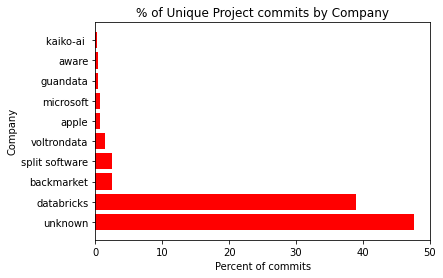

In [162]:
plt.barh(df_commits_by_company_delta['company_clean_3'].head(10), df_commits_by_company_delta['company_pct_project_commits'].head(10), color = "red")
plt.xlabel("Percent of commits") 
plt.ylabel("Company") 
plt.title("% of Unique Project commits by Company")
plt.show()

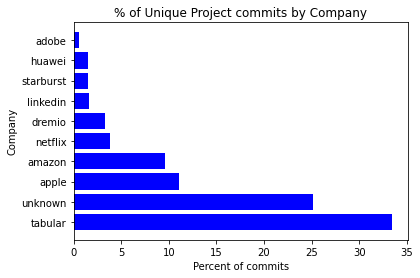

In [163]:
plt.barh(df_commits_by_company_iceberg['company_clean_3'].head(10), df_commits_by_company_iceberg['company_pct_project_commits'].head(10), color = "blue")
plt.xlabel("Percent of commits")
plt.ylabel("Company")
plt.title("% of Unique Project commits by Company")
plt.show()

## How many unique committers by company?

In [152]:
df_unique_committers = df_commits[['login','project']].drop_duplicates(subset='login', keep='first')
df_unique_committers_profiles = pd.merge(df_unique_committers, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_unique_committers_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_unique_committers_profiles.sort_values(by='login').head()

,login,project,company_clean_3
513,0x3E6,hudi,unknown
175,0xffmeta,iceberg,unknown
365,1032851561,hudi,unknown
127,20100507,iceberg,unknown
448,5herhom,hudi,unknown


In [153]:
df_committers_by_company = df_unique_committers_profiles[['project','company_clean_3']].groupby(['project','company_clean_3'], as_index=False).size().rename(columns={'size':'company_committers'})
df_committers_by_company.sort_values(by='company_committers', ascending=False).head()

,project,company_clean_3,company_committers
136,hudi,unknown,229
61,delta,unknown,156
225,iceberg,unknown,156
19,delta,databricks,85
147,iceberg,amazon,24


In [154]:
df_committers_by_project = df_unique_committers_profiles[['project']].groupby(['project'], as_index=False).size().rename(columns={'size':'project_committers'})
df_committers_by_project.sort_values(by='project_committers', ascending=False).head()

,project,project_committers
1,hudi,341
2,iceberg,331
0,delta,318


In [155]:
df_committers_by_company = pd.merge(df_committers_by_company,df_committers_by_project, on='project', how='left')
df_committers_by_company[['company_pct_project_committers']] = 100*(df_committers_by_company['company_committers']/df_committers_by_company['project_committers'])
df_committers_by_company.sort_values(by='company_pct_project_committers', ascending=False).head()

,project,company_clean_3,company_committers,project_committers,company_pct_project_committers
136,hudi,unknown,229,341,67.155425
61,delta,unknown,156,318,49.056604
225,iceberg,unknown,156,331,47.129909
19,delta,databricks,85,318,26.729560
147,iceberg,amazon,24,331,7.250755


In [156]:
df_committers_by_company_delta = df_committers_by_company[df_committers_by_company['project'] == 'delta'].sort_values(by='company_pct_project_committers', ascending=False)
df_committers_by_company_iceberg = df_committers_by_company[df_committers_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_committers', ascending=False)
df_committers_by_company_hudi = df_committers_by_company[df_committers_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_committers', ascending=False)

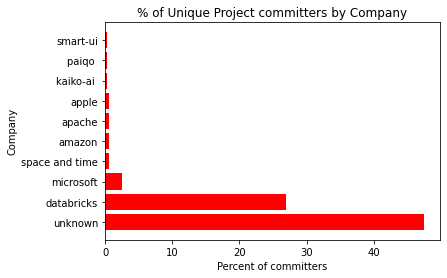

In [170]:
plt.barh(df_committers_by_company_delta['company_clean_3'].head(10), df_committers_by_company_delta['company_pct_project_committers'].head(10), color = "red")
plt.xlabel("Percent of committers") 
plt.ylabel("Company") 
plt.title("% of Unique Project committers by Company")
plt.show()

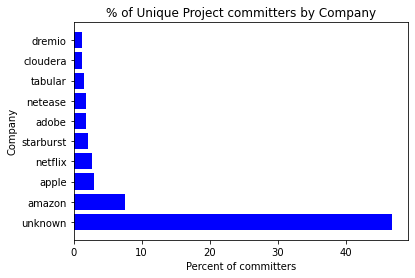

In [171]:
plt.barh(df_committers_by_company_iceberg['company_clean_3'].head(10), df_committers_by_company_iceberg['company_pct_project_committers'].head(10), color = "blue")
plt.xlabel("Percent of committers") 
plt.ylabel("Company") 
plt.title("% of Unique Project committers by Company")
plt.show()

## How many contributions by company?

In [63]:
df_all_proj_contributors.head()

,login,url,contributions,repo,project
0,rdblue,https://api.github.com/users/rdblue,667,apache/iceberg,iceberg
1,aokolnychyi,https://api.github.com/users/aokolnychyi,329,apache/iceberg,iceberg
2,Fokko,https://api.github.com/users/Fokko,285,apache/iceberg,iceberg
3,nastra,https://api.github.com/users/nastra,205,apache/iceberg,iceberg
4,kbendick,https://api.github.com/users/kbendick,181,apache/iceberg,iceberg


In [172]:
df_contributions_profiles = pd.merge(df_all_proj_contributors, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_contributions_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_contributions_profiles.head()

,login,url,contributions,repo,project,company_clean_3
0,rdblue,https://api.github.com/users/rdblue,667,apache/iceberg,iceberg,tabular
1,aokolnychyi,https://api.github.com/users/aokolnychyi,329,apache/iceberg,iceberg,apple
2,Fokko,https://api.github.com/users/Fokko,285,apache/iceberg,iceberg,tabular
3,nastra,https://api.github.com/users/nastra,205,apache/iceberg,iceberg,tabular
4,kbendick,https://api.github.com/users/kbendick,181,apache/iceberg,iceberg,tabular


In [173]:
df_contributions_by_company = df_contributions_profiles.groupby(['project','company_clean_3'], as_index=False)['contributions'].agg('sum').rename(columns={'contributions':'company_contributions'})
df_contributions_by_company.sort_values(by='company_contributions', ascending=False).head()

,project,company_clean_3,company_contributions
150,hudi,unknown,1749
68,delta,unknown,1613
23,delta,databricks,1417
229,iceberg,tabular,1372
239,iceberg,unknown,949


In [174]:
df_contributions_by_project = df_contributions_profiles.groupby(['project'], as_index=False)['contributions'].agg('sum').rename(columns={'contributions':'project_contributions'})
df_contributions_by_project.sort_values(by='project_contributions', ascending=False).head()

,project,project_contributions
2,iceberg,4015
1,hudi,3908
0,delta,3520


In [177]:
df_contributions_by_company = pd.merge(df_contributions_by_company,df_contributions_by_project, on='project', how='left')
df_contributions_by_company[['company_pct_project_contributions']] = 100*(df_contributions_by_company['company_contributions']/df_contributions_by_company['project_contributions'])
df_contributions_by_company.sort_values(by='company_pct_project_contributions', ascending=False).head()

,project,company_clean_3,company_contributions,project_contributions,company_pct_project_contributions
68,delta,unknown,1613,3520,45.823864
150,hudi,unknown,1749,3908,44.754350
23,delta,databricks,1417,3520,40.255682
229,iceberg,tabular,1372,4015,34.171856
239,iceberg,unknown,949,4015,23.636364


In [178]:
df_contributions_by_company_delta = df_contributions_by_company[df_contributions_by_company['project'] == 'delta'].sort_values(by='company_pct_project_contributions', ascending=False)
df_contributions_by_company_iceberg = df_contributions_by_company[df_contributions_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_contributions', ascending=False)
df_contributions_by_company_hudi = df_contributions_by_company[df_contributions_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_contributions', ascending=False)

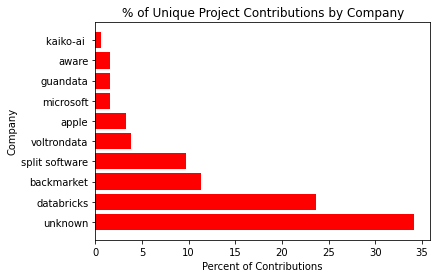

In [179]:
plt.barh(df_contributions_by_company_delta['company_clean_3'].head(10), df_contributions_by_company_iceberg['company_pct_project_contributions'].head(10), color = "red")
plt.xlabel("Percent of Contributions") 
plt.ylabel("Company") 
plt.title("% of Unique Project Contributions by Company")
plt.show()

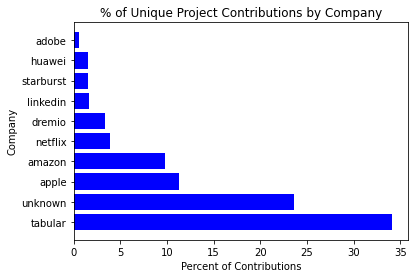

In [180]:
plt.barh(df_contributions_by_company_iceberg['company_clean_3'].head(10), df_contributions_by_company_iceberg['company_pct_project_contributions'].head(10), color = "blue")
plt.xlabel("Percent of Contributions") 
plt.ylabel("Company") 
plt.title("% of Unique Project Contributions by Company")
plt.show()

## How many unique contributors by company?

In [189]:
df_unique_contributors = df_contributions_profiles[['login','project']].drop_duplicates(subset='login', keep='first')
df_unique_contributors_profiles = pd.merge(df_unique_contributors, df_unique_profiles[['company_clean_3','login']], on='login', how='left')
df_unique_contributors_profiles['company_clean_3'].fillna('unknown', inplace=True)
df_unique_contributors_profiles.sort_values(by='login').head()

,login,project,company_clean_3
468,0x3E6,hudi,unknown
116,0xffmeta,iceberg,unknown
459,1032851561,hudi,unknown
147,20100507,iceberg,unknown
439,5herhom,hudi,unknown


In [190]:
df_contributors_by_company = df_unique_contributors_profiles[['project','company_clean_3']].groupby(['project','company_clean_3'], as_index=False).size().rename(columns={'size':'company_contributors'})
df_contributors_by_company.sort_values(by='company_contributors', ascending=False).head()

,project,company_clean_3,company_contributors
140,hudi,unknown,228
229,iceberg,unknown,154
64,delta,unknown,150
21,delta,databricks,85
151,iceberg,amazon,25


In [191]:
df_contributors_by_project = df_unique_contributors_profiles[['project']].groupby(['project'], as_index=False).size().rename(columns={'size':'project_contributors'})
df_contributors_by_project.sort_values(by='project_contributors', ascending=False).head()

,project,project_contributors
1,hudi,341
2,iceberg,330
0,delta,316


In [192]:
df_contributors_by_company = pd.merge(df_contributors_by_company,df_contributors_by_project, on='project', how='left')
df_contributors_by_company[['company_pct_project_contributors']] = 100*(df_contributors_by_company['company_contributors']/df_contributors_by_company['project_contributors'])
df_contributors_by_company.sort_values(by='company_pct_project_contributors', ascending=False).head()

,project,company_clean_3,company_contributors,project_contributors,company_pct_project_contributors
140,hudi,unknown,228,341,66.862170
64,delta,unknown,150,316,47.468354
229,iceberg,unknown,154,330,46.666667
21,delta,databricks,85,316,26.898734
151,iceberg,amazon,25,330,7.575758


In [193]:
df_contributors_by_company_delta = df_contributors_by_company[df_contributors_by_company['project'] == 'delta'].sort_values(by='company_pct_project_contributors', ascending=False)
df_contributors_by_company_iceberg = df_contributors_by_company[df_contributors_by_company['project'] == 'iceberg'].sort_values(by='company_pct_project_contributors', ascending=False)
df_contributors_by_company_hudi = df_contributors_by_company[df_contributors_by_company['project'] == 'hudi'].sort_values(by='company_pct_project_contributors', ascending=False)

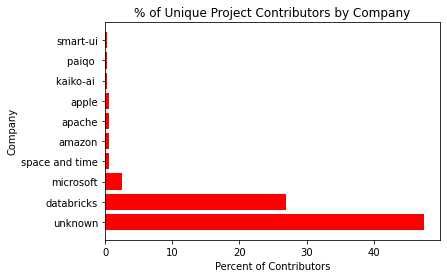

In [196]:
plt.barh(df_contributors_by_company_delta['company_clean_3'].head(10), df_contributors_by_company_delta['company_pct_project_contributors'].head(10), color = "red")
plt.xlabel("Percent of Contributors") 
plt.ylabel("Company") 
plt.title("% of Unique Project Contributors by Company")
plt.show()

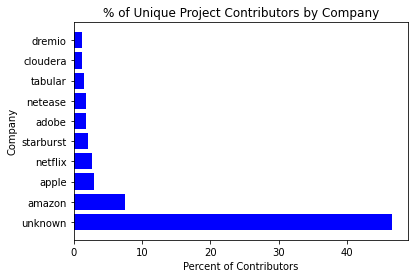

In [197]:
plt.barh(df_contributors_by_company_iceberg['company_clean_3'].head(10), df_contributors_by_company_iceberg['company_pct_project_contributors'].head(10), color = "blue")
plt.xlabel("Percent of Contributors") 
plt.ylabel("Company") 
plt.title("% of Unique Project Contributors by Company")
plt.show()